<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_dkl_plasmons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DKL-GPR for active learning
This notebook demonstrates how to use a deep kernel learning (DKL)-based Gaussian process regression (GPR) for data reconstruction and automated experiments. We will be using the pre-acquired experimental dataset on plasmonic nanoparticles (HAADF + EELS) from Kevin Roccapriore.

*Prepared by Maxim Ziatdinov (August 2021)*

Intallations:

In [1]:
!pip install -q torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1
!pip install -q --upgrade git+https://github.com/pycroscopy/atomai.git

     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 17.4 MB 1.1 MB/s 
     |████████████████████████████████| 7.1 MB 14.6 MB/s 
     |████████████████████████████████| 498 kB 5.2 MB/s 
     |████████████████████████████████| 475 kB 44.5 MB/s 
     |████████████████████████████████| 193 kB 5.1 MB/s 
     |████████████████████████████████| 865 kB 49.1 MB/s 


Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import atomai as aoi

Download training data:

In [2]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [66]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [67]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra).

In [5]:
window_size = 12

coordinates = aoi.utils.get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = aoi.utils.extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

((3264, 12, 12), (3264, 93))

Normalize data:

In [7]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of largest plasmonic peak but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First do it for a single spectrum:

25 0.7151328805097958


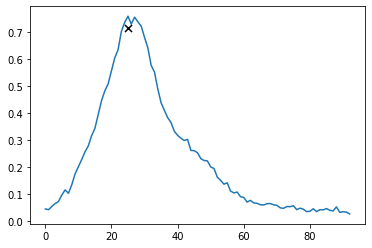

In [10]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Same but for all the data:

In [11]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

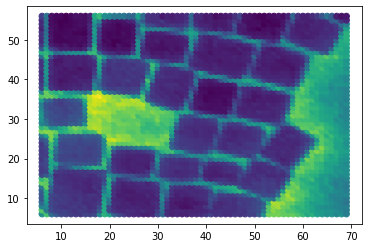

In [13]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)

## DKL on full data

Prepare data for training:

In [14]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((3264, 144), (3264,))

Train:

In [15]:
data_dim = X.shape[-1]

dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp.fit(X, y, training_cycles=100)

Epoch 1/100 ... Training loss: 0.7581
Epoch 10/100 ... Training loss: 0.7123
Epoch 20/100 ... Training loss: 0.6735
Epoch 30/100 ... Training loss: 0.6348
Epoch 40/100 ... Training loss: 0.5954
Epoch 50/100 ... Training loss: 0.5549
Epoch 60/100 ... Training loss: 0.5134
Epoch 70/100 ... Training loss: 0.471
Epoch 80/100 ... Training loss: 0.4272
Epoch 90/100 ... Training loss: 0.3844
Epoch 100/100 ... Training loss: 0.3384


Make a "prediction" on the training data (since we used all the data for training, our training and test datasets are the same, that is, we basically look at how well our model was able to "fit" the data):

In [16]:
mean, var = dklgp.predict(X, batch_size=len(X))

Text(0.5, 1.0, 'DKL uncertainty')

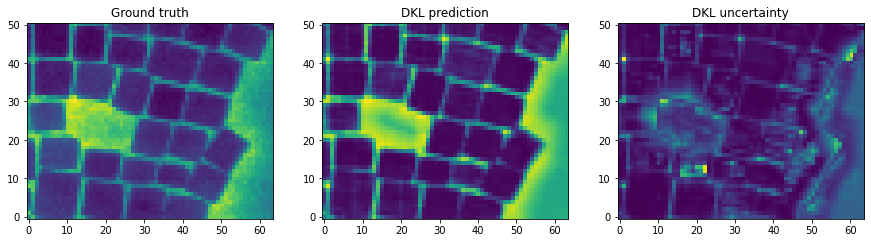

In [17]:
s1, s2 = img.shape[0] - window_size+1, img.shape[1] - window_size+1

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.imshow(peaks_all.reshape(s1, s2), origin="lower")
ax1.set_title("Ground truth")
ax2.imshow(mean.reshape(s1, s2))
ax2.set_title("DKL prediction")
ax2.imshow(mean.reshape(s1, s2), origin="lower")
ax3.imshow(var.reshape(s1, s2), origin="lower")
ax3.set_title("DKL uncertainty")

We can also visualize our latent/embedding space:

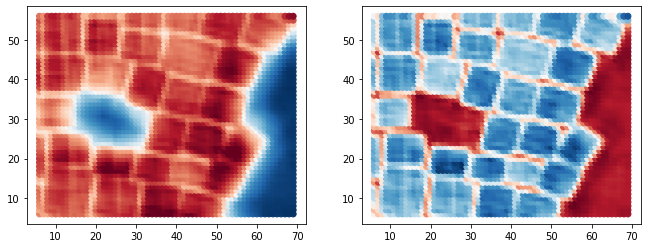

In [25]:
embeded = dklgp.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

## DKL on partial data

Now let's use only a part of the data for training:

In [26]:
split_ = 30
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

In [27]:
dklgp1 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp1.fit(X_train, y_train, training_cycles=100)

Epoch 1/100 ... Training loss: 0.768
Epoch 10/100 ... Training loss: 0.7272
Epoch 20/100 ... Training loss: 0.6866
Epoch 30/100 ... Training loss: 0.6481
Epoch 40/100 ... Training loss: 0.6064
Epoch 50/100 ... Training loss: 0.5645
Epoch 60/100 ... Training loss: 0.5183
Epoch 70/100 ... Training loss: 0.4775
Epoch 80/100 ... Training loss: 0.4319
Epoch 90/100 ... Training loss: 0.3884
Epoch 100/100 ... Training loss: 0.3418


Make a prediction on all the data:

In [28]:
mean, var = dklgp1.predict(X, batch_size=len(X))

Plot the prediction. The dotted vertical line divides the part used for training (left hand side) from the testing (right hand side) part.

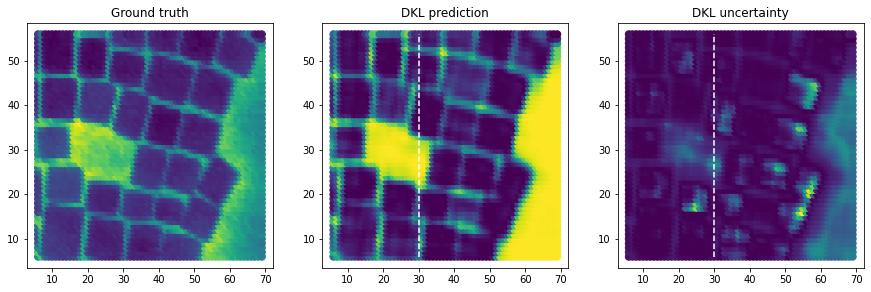

In [29]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax1.set_title("Ground truth")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax2.set_title("DKL prediction")
ax3.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax3.set_title("DKL uncertainty")
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax3.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')

## Active learning

Here we are going to use DKL for active learning aimed at identifying regions of the sample where a particular behavior (plasmon resonance peak) is maximized. We start with just three "measured" points:

In [58]:
# Here X_train and y_train are our measured image patches (HAADF) and spectra/peaks (EELS),
# whereas X_test and y_test are the "unkwown" ones. The indices_train are grid coordinates of the measured points,
# whereas the indices_test are the grid coordinates of the remaining available points on the grid
(X_train, X_test, y_train, y_test,
  indices_train, indices_test) = train_test_split(
      X, y, indices_all, test_size=0.999, shuffle=True, random_state=4)

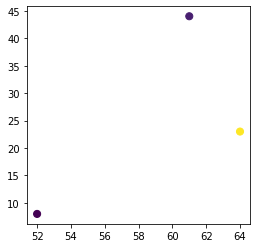

In [59]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c=y_train)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/40
Epoch 1/50 ... Training loss: 1.0305
Epoch 10/50 ... Training loss: 0.9912
Epoch 20/50 ... Training loss: 0.9114
Epoch 30/50 ... Training loss: 0.848
Epoch 40/50 ... Training loss: 0.7916
Epoch 50/50 ... Training loss: 0.7366


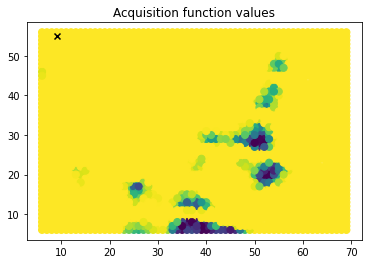

2/40
Epoch 1/50 ... Training loss: 1.0004
Epoch 10/50 ... Training loss: 0.9513
Epoch 20/50 ... Training loss: 0.8911
Epoch 30/50 ... Training loss: 0.837
Epoch 40/50 ... Training loss: 0.7869
Epoch 50/50 ... Training loss: 0.7404


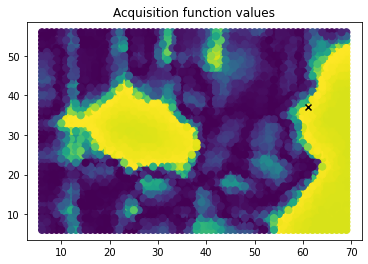

3/40
Epoch 1/50 ... Training loss: 0.984
Epoch 10/50 ... Training loss: 0.944
Epoch 20/50 ... Training loss: 0.8789
Epoch 30/50 ... Training loss: 0.8242
Epoch 40/50 ... Training loss: 0.7742
Epoch 50/50 ... Training loss: 0.7286


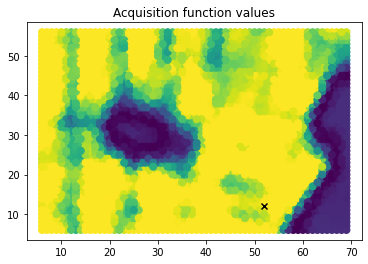

4/40
Epoch 1/50 ... Training loss: 0.9563
Epoch 10/50 ... Training loss: 0.9119
Epoch 20/50 ... Training loss: 0.8555
Epoch 30/50 ... Training loss: 0.805
Epoch 40/50 ... Training loss: 0.7589
Epoch 50/50 ... Training loss: 0.7148


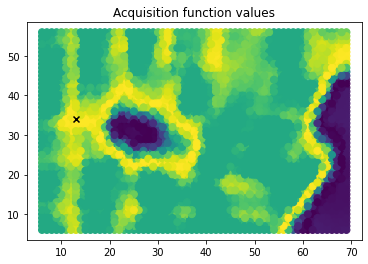

5/40
Epoch 1/50 ... Training loss: 0.9348
Epoch 10/50 ... Training loss: 0.8955
Epoch 20/50 ... Training loss: 0.8376
Epoch 30/50 ... Training loss: 0.7891
Epoch 40/50 ... Training loss: 0.7446
Epoch 50/50 ... Training loss: 0.7017


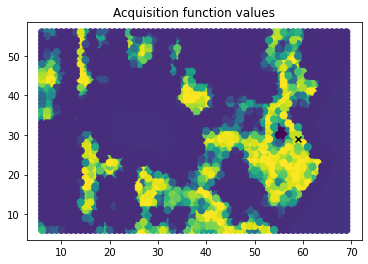

6/40
Epoch 1/50 ... Training loss: 0.929
Epoch 10/50 ... Training loss: 0.8905
Epoch 20/50 ... Training loss: 0.8373
Epoch 30/50 ... Training loss: 0.7873
Epoch 40/50 ... Training loss: 0.7437
Epoch 50/50 ... Training loss: 0.6996


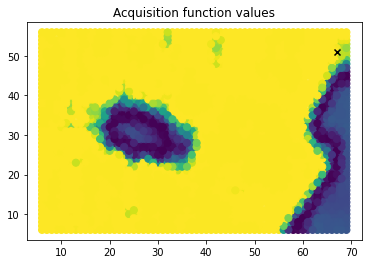

7/40
Epoch 1/50 ... Training loss: 0.916
Epoch 10/50 ... Training loss: 0.8817
Epoch 20/50 ... Training loss: 0.8243
Epoch 30/50 ... Training loss: 0.7771
Epoch 40/50 ... Training loss: 0.7364
Epoch 50/50 ... Training loss: 0.6915


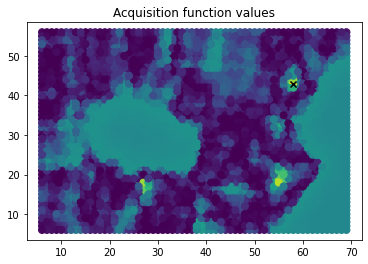

8/40
Epoch 1/50 ... Training loss: 0.9062
Epoch 10/50 ... Training loss: 0.8679
Epoch 20/50 ... Training loss: 0.8198
Epoch 30/50 ... Training loss: 0.7739
Epoch 40/50 ... Training loss: 0.7304
Epoch 50/50 ... Training loss: 0.6883


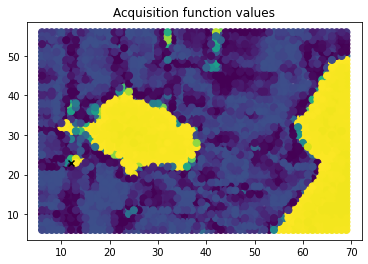

9/40
Epoch 1/50 ... Training loss: 0.896
Epoch 10/50 ... Training loss: 0.8538
Epoch 20/50 ... Training loss: 0.8129
Epoch 30/50 ... Training loss: 0.7663
Epoch 40/50 ... Training loss: 0.728
Epoch 50/50 ... Training loss: 0.6806


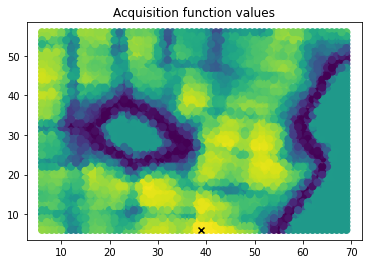

10/40
Epoch 1/50 ... Training loss: 0.8888
Epoch 10/50 ... Training loss: 0.8499
Epoch 20/50 ... Training loss: 0.8049
Epoch 30/50 ... Training loss: 0.7616
Epoch 40/50 ... Training loss: 0.7184
Epoch 50/50 ... Training loss: 0.676


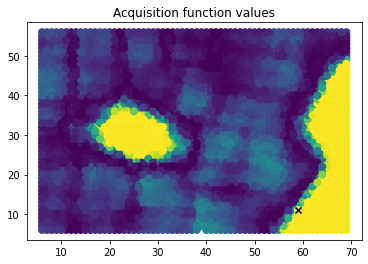

11/40
Epoch 1/50 ... Training loss: 0.8868
Epoch 10/50 ... Training loss: 0.8527
Epoch 20/50 ... Training loss: 0.8048
Epoch 30/50 ... Training loss: 0.7598
Epoch 40/50 ... Training loss: 0.7164
Epoch 50/50 ... Training loss: 0.6734


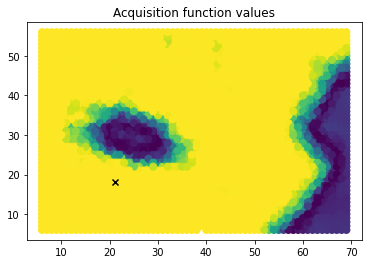

12/40
Epoch 1/50 ... Training loss: 0.8795
Epoch 10/50 ... Training loss: 0.8502
Epoch 20/50 ... Training loss: 0.801
Epoch 30/50 ... Training loss: 0.7552
Epoch 40/50 ... Training loss: 0.7115
Epoch 50/50 ... Training loss: 0.6684


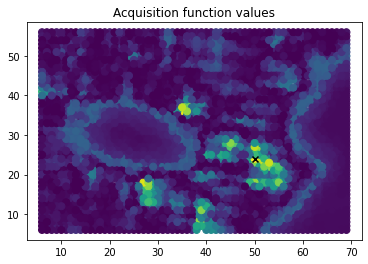

13/40
Epoch 1/50 ... Training loss: 0.8733
Epoch 10/50 ... Training loss: 0.8364
Epoch 20/50 ... Training loss: 0.7921
Epoch 30/50 ... Training loss: 0.7493
Epoch 40/50 ... Training loss: 0.7069
Epoch 50/50 ... Training loss: 0.6645


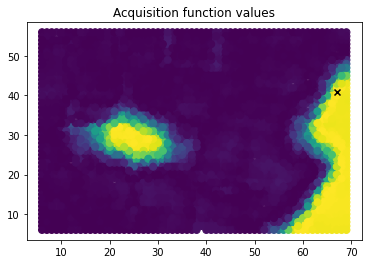

14/40
Epoch 1/50 ... Training loss: 0.8721
Epoch 10/50 ... Training loss: 0.8448
Epoch 20/50 ... Training loss: 0.7966
Epoch 30/50 ... Training loss: 0.7499
Epoch 40/50 ... Training loss: 0.706
Epoch 50/50 ... Training loss: 0.6627


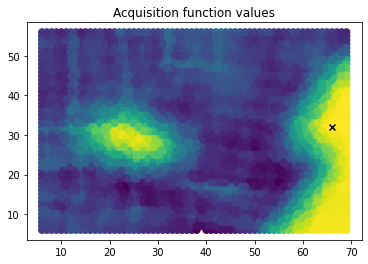

15/40
Epoch 1/50 ... Training loss: 0.8701
Epoch 10/50 ... Training loss: 0.8425
Epoch 20/50 ... Training loss: 0.7986
Epoch 30/50 ... Training loss: 0.7521
Epoch 40/50 ... Training loss: 0.7059
Epoch 50/50 ... Training loss: 0.6631


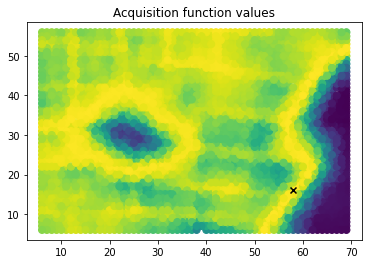

16/40
Epoch 1/50 ... Training loss: 0.8659
Epoch 10/50 ... Training loss: 0.8321
Epoch 20/50 ... Training loss: 0.7882
Epoch 30/50 ... Training loss: 0.7449
Epoch 40/50 ... Training loss: 0.7018
Epoch 50/50 ... Training loss: 0.6589


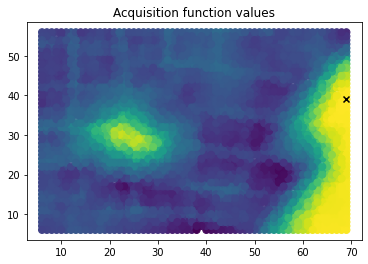

17/40
Epoch 1/50 ... Training loss: 0.8635
Epoch 10/50 ... Training loss: 0.839
Epoch 20/50 ... Training loss: 0.7914
Epoch 30/50 ... Training loss: 0.746
Epoch 40/50 ... Training loss: 0.7009
Epoch 50/50 ... Training loss: 0.6564


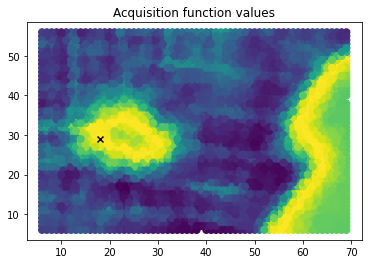

18/40
Epoch 1/50 ... Training loss: 0.8648
Epoch 10/50 ... Training loss: 0.8389
Epoch 20/50 ... Training loss: 0.7893
Epoch 30/50 ... Training loss: 0.7445
Epoch 40/50 ... Training loss: 0.7009
Epoch 50/50 ... Training loss: 0.6574


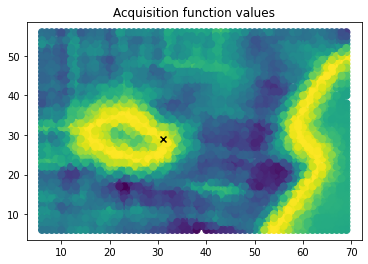

19/40
Epoch 1/50 ... Training loss: 0.8633
Epoch 10/50 ... Training loss: 0.8349
Epoch 20/50 ... Training loss: 0.7845
Epoch 30/50 ... Training loss: 0.7406
Epoch 40/50 ... Training loss: 0.6974
Epoch 50/50 ... Training loss: 0.6542


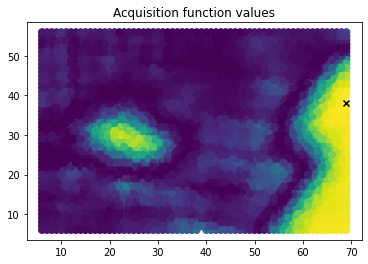

20/40
Epoch 1/50 ... Training loss: 0.8606
Epoch 10/50 ... Training loss: 0.8325
Epoch 20/50 ... Training loss: 0.7861
Epoch 30/50 ... Training loss: 0.7405
Epoch 40/50 ... Training loss: 0.6966
Epoch 50/50 ... Training loss: 0.6528


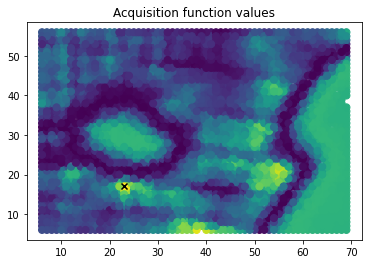

21/40
Epoch 1/50 ... Training loss: 0.8577
Epoch 10/50 ... Training loss: 0.8253
Epoch 20/50 ... Training loss: 0.7818
Epoch 30/50 ... Training loss: 0.7384
Epoch 40/50 ... Training loss: 0.6941
Epoch 50/50 ... Training loss: 0.6494


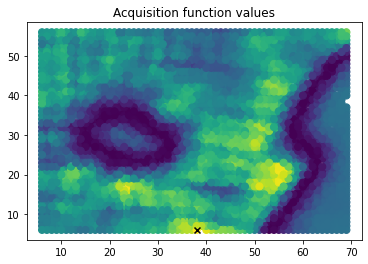

22/40
Epoch 1/50 ... Training loss: 0.8546
Epoch 10/50 ... Training loss: 0.8242
Epoch 20/50 ... Training loss: 0.78
Epoch 30/50 ... Training loss: 0.7355
Epoch 40/50 ... Training loss: 0.691
Epoch 50/50 ... Training loss: 0.6468


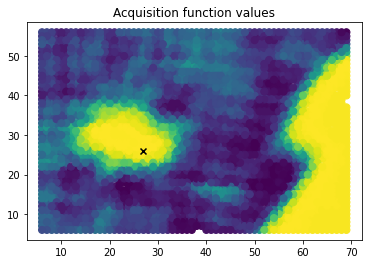

23/40
Epoch 1/50 ... Training loss: 0.8555
Epoch 10/50 ... Training loss: 0.8221
Epoch 20/50 ... Training loss: 0.775
Epoch 30/50 ... Training loss: 0.7317
Epoch 40/50 ... Training loss: 0.689
Epoch 50/50 ... Training loss: 0.6462


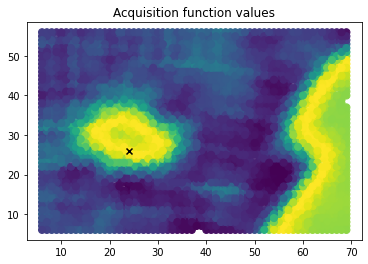

24/40
Epoch 1/50 ... Training loss: 0.8553
Epoch 10/50 ... Training loss: 0.8247
Epoch 20/50 ... Training loss: 0.7788
Epoch 30/50 ... Training loss: 0.734
Epoch 40/50 ... Training loss: 0.6903
Epoch 50/50 ... Training loss: 0.6472


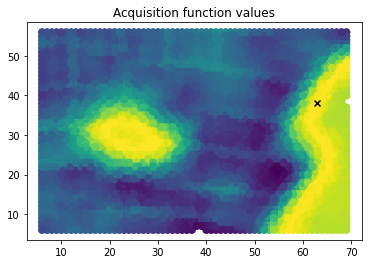

25/40
Epoch 1/50 ... Training loss: 0.8522
Epoch 10/50 ... Training loss: 0.8191
Epoch 20/50 ... Training loss: 0.7731
Epoch 30/50 ... Training loss: 0.7276
Epoch 40/50 ... Training loss: 0.6849
Epoch 50/50 ... Training loss: 0.6423


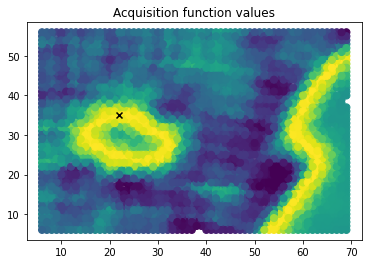

26/40
Epoch 1/50 ... Training loss: 0.8509
Epoch 10/50 ... Training loss: 0.8114
Epoch 20/50 ... Training loss: 0.7686
Epoch 30/50 ... Training loss: 0.7267
Epoch 40/50 ... Training loss: 0.6845
Epoch 50/50 ... Training loss: 0.6421


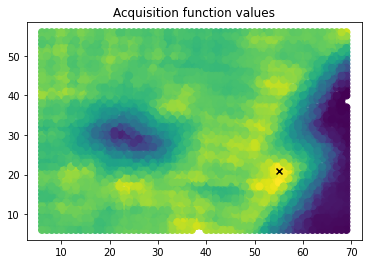

27/40
Epoch 1/50 ... Training loss: 0.8485
Epoch 10/50 ... Training loss: 0.8148
Epoch 20/50 ... Training loss: 0.7704
Epoch 30/50 ... Training loss: 0.7262
Epoch 40/50 ... Training loss: 0.6835
Epoch 50/50 ... Training loss: 0.6403


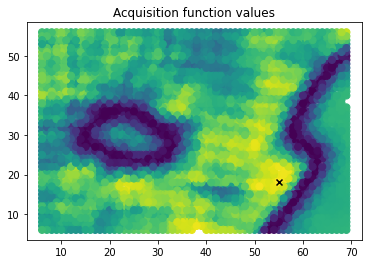

28/40
Epoch 1/50 ... Training loss: 0.8458
Epoch 10/50 ... Training loss: 0.8138
Epoch 20/50 ... Training loss: 0.7692
Epoch 30/50 ... Training loss: 0.7256
Epoch 40/50 ... Training loss: 0.6825
Epoch 50/50 ... Training loss: 0.6397


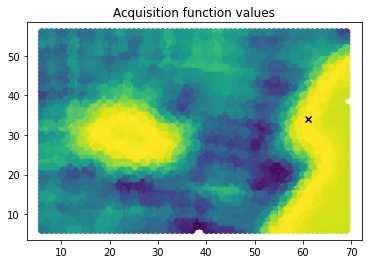

29/40
Epoch 1/50 ... Training loss: 0.844
Epoch 10/50 ... Training loss: 0.8054
Epoch 20/50 ... Training loss: 0.7632
Epoch 30/50 ... Training loss: 0.7488
Epoch 40/50 ... Training loss: 0.6802
Epoch 50/50 ... Training loss: 0.6375


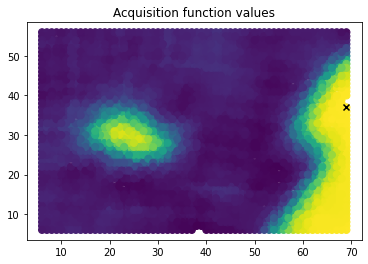

30/40
Epoch 1/50 ... Training loss: 0.8423
Epoch 10/50 ... Training loss: 0.8056
Epoch 20/50 ... Training loss: 0.7657
Epoch 30/50 ... Training loss: 0.7224
Epoch 40/50 ... Training loss: 0.6793
Epoch 50/50 ... Training loss: 0.6365


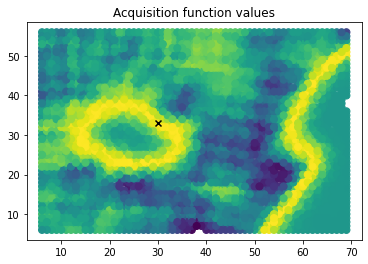

31/40
Epoch 1/50 ... Training loss: 0.8405
Epoch 10/50 ... Training loss: 0.8056
Epoch 20/50 ... Training loss: 0.7615
Epoch 30/50 ... Training loss: 0.719
Epoch 40/50 ... Training loss: 0.6769
Epoch 50/50 ... Training loss: 0.6447


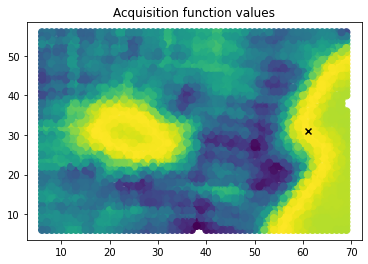

32/40
Epoch 1/50 ... Training loss: 0.8394
Epoch 10/50 ... Training loss: 0.8026
Epoch 20/50 ... Training loss: 0.7618
Epoch 30/50 ... Training loss: 0.7186
Epoch 40/50 ... Training loss: 0.6752
Epoch 50/50 ... Training loss: 0.6335


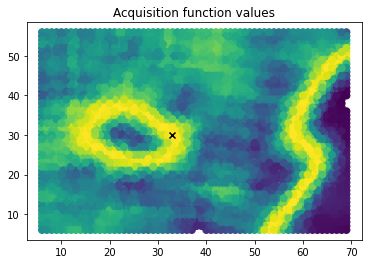

33/40
Epoch 1/50 ... Training loss: 0.8381
Epoch 10/50 ... Training loss: 0.8058
Epoch 20/50 ... Training loss: 0.7611
Epoch 30/50 ... Training loss: 0.7174
Epoch 40/50 ... Training loss: 0.6748
Epoch 50/50 ... Training loss: 0.6325


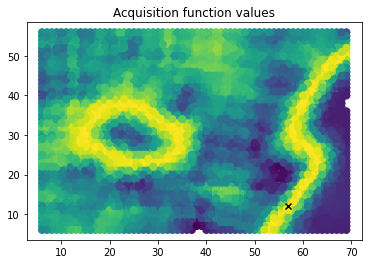

34/40
Epoch 1/50 ... Training loss: 0.8368
Epoch 10/50 ... Training loss: 0.7994
Epoch 20/50 ... Training loss: 0.7591
Epoch 30/50 ... Training loss: 0.7165
Epoch 40/50 ... Training loss: 0.6749
Epoch 50/50 ... Training loss: 0.6455


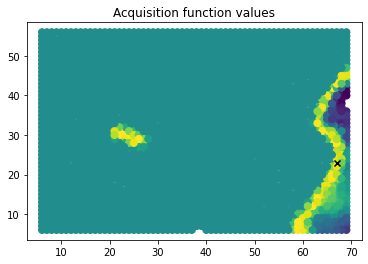

35/40
Epoch 1/50 ... Training loss: 0.8348
Epoch 10/50 ... Training loss: 0.7983
Epoch 20/50 ... Training loss: 0.7583
Epoch 30/50 ... Training loss: 0.7158
Epoch 40/50 ... Training loss: 0.6734
Epoch 50/50 ... Training loss: 0.6311


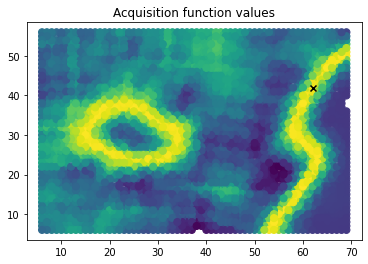

36/40
Epoch 1/50 ... Training loss: 0.8328
Epoch 10/50 ... Training loss: 0.7977
Epoch 20/50 ... Training loss: 0.7552
Epoch 30/50 ... Training loss: 0.7134
Epoch 40/50 ... Training loss: 0.6714
Epoch 50/50 ... Training loss: 0.6299


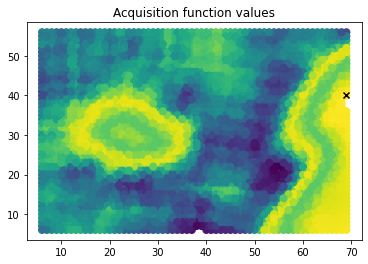

37/40
Epoch 1/50 ... Training loss: 0.8316
Epoch 10/50 ... Training loss: 0.7997
Epoch 20/50 ... Training loss: 0.754
Epoch 30/50 ... Training loss: 0.7113
Epoch 40/50 ... Training loss: 0.6702
Epoch 50/50 ... Training loss: 0.629


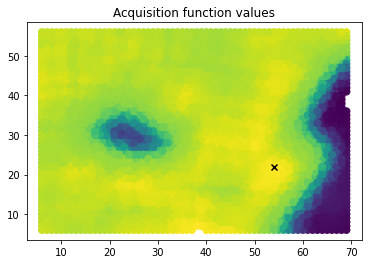

38/40
Epoch 1/50 ... Training loss: 0.83
Epoch 10/50 ... Training loss: 0.7919
Epoch 20/50 ... Training loss: 0.7502
Epoch 30/50 ... Training loss: 0.7092
Epoch 40/50 ... Training loss: 0.6679
Epoch 50/50 ... Training loss: 0.6259


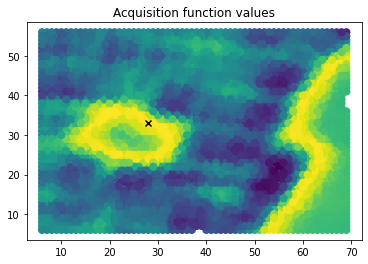

39/40
Epoch 1/50 ... Training loss: 0.8291
Epoch 10/50 ... Training loss: 0.7967
Epoch 20/50 ... Training loss: 0.7524
Epoch 30/50 ... Training loss: 0.7086
Epoch 40/50 ... Training loss: 0.6667
Epoch 50/50 ... Training loss: 0.6254


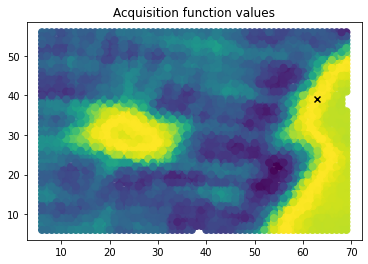

40/40
Epoch 1/50 ... Training loss: 0.8274
Epoch 10/50 ... Training loss: 0.7954
Epoch 20/50 ... Training loss: 0.7582
Epoch 30/50 ... Training loss: 0.7116
Epoch 40/50 ... Training loss: 0.6667
Epoch 50/50 ... Training loss: 0.6251


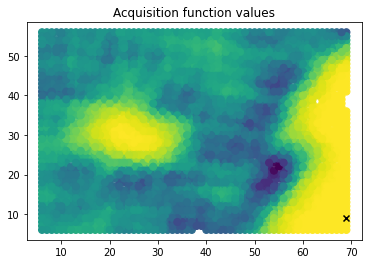

In [60]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=50, c=obj)
    next_point = indices_test[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_train.shape[-1]

exploration_steps = 40

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dklgp2 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp2.fit(X_train, y_train, training_cycles=50)
    # Thompson sampling
    obj, next_point_idx = dklgp2.thompson(X_test)
    # Select next point to "measure"
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(indices_test, obj)
    # Append to the arrays of measured points
    X_train = np.append(X_train, X_test[next_point_idx][None], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)
    indices_train = np.append(indices_train, next_point[None], 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

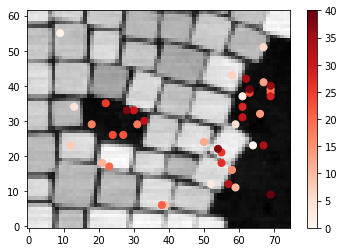

In [61]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_train[2:, 1], indices_train[2:, 0], c=np.arange(len(indices_train[2:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

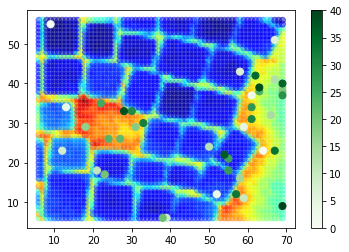

In [65]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_train[2:, 1], indices_train[2:, 0], c=np.arange(len(indices_train[2:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of intetest is maximized. We note that in addition to the built-in Thompson sampler used here, one can utilize different types of [acquisition functions](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf) for selecting the next measurement points.